Automation of Feature Creation

src : https://www.kaggle.com/datasets/blackbee2016/automation-of-feature-creation/data
columns : 669 columns

In [19]:
!pip install pip==23.2.1 setuptools==65.5.1

In [20]:
!pip install deap  pyswarm pywhale xgboost matplotlib lightgbm catboost imbalanced-learn

In [21]:
# connect S3 bucket
bucket = "mscproject05"
datakey = "train.csv"
data_location = f"s3://{bucket}/{datakey}"

print(data_location)

s3://mscproject05/train.csv


In [22]:
# import the library

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import time

In [23]:
# Load dataset
df = pd.read_csv(data_location)
df.head(5)

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_1,...,LabelPSum(bureau_train.csv.SK_ID_BUREAU) where DAYS_CREDIT <= -983.5,LabelPSum(bureau_train.csv.SK_ID_BUREAU) where DAYS_CREDIT_ENDDATE > -426.5,LabelPSum(credit_card_balance_train.csv.CNT_DRAWINGS_ATM_CURRENT) where AMT_INST_MIN_REGULARITY > 0.0225,LabelPSum(installments_payments_train.csv.AMT_INSTALMENT) where AMT_PAYMENT > 15929.28,"LabelPSum(installments_payments_train.csv.DAYS_ENTRY_PAYMENT) where DAYS_INSTALMENT in ]-1654.5, -821.5]",LabelPSum(installments_payments_train.csv.DAYS_INSTALMENT) where AMT_PAYMENT <= 3375.45,LabelPSum(installments_payments_train.csv.NUM_INSTALMENT_NUMBER) where AMT_PAYMENT > 8088.8175,LabelPSum(installments_payments_train.csv.SK_ID_PREV) where AMT_INSTALMENT > 16549.6725,LabelPYEARS_BEGINEXPLUATATION_AVG,ProbTARGET1
0,24700.5,406597.5,351000.0,M,-9461,-637,-2120,2.0,2.0,0.083037,...,]17504865;+inf[,]5055192.5;33971364],]-inf;0.5],]18152.6625;+inf[,]-inf;-107062],]-inf;-55391],]96.5;+inf[,]-inf;5925941.5],]-inf;0.97345],0.246611
1,35698.5,1293502.5,1129500.0,F,-16765,-1188,-291,0.0,0.0,0.311267,...,]5044331;17504865],]5055192.5;33971364],]-inf;0.5],]18152.6625;+inf[,]-inf;-107062],]-inf;-55391],]9.5;96.5],]5925941.5;+inf[,]0.97345;0.99035],0.011116
2,6750.0,135000.0,135000.0,M,-19046,-225,-2531,0.0,0.0,NaN,...,]5044331;17504865],]5055192.5;33971364],]-inf;0.5],]-inf;18152.6625],]-inf;-107062],]-inf;-55391],]-inf;9.5],]-inf;5925941.5],]-inf;0.97345],0.027319
3,29686.5,312682.5,297000.0,F,-19005,-3039,-2437,0.0,0.0,NaN,...,]-inf;5044331],]-inf;5055192.5],]-inf;0.5],]18152.6625;+inf[,]-inf;-107062],]-7612.5;+inf[,]9.5;96.5],]5925941.5;+inf[,]-inf;0.97345],0.084332
4,21865.5,513000.0,513000.0,M,-19932,-3038,-3458,0.0,0.0,NaN,...,]5044331;17504865],]-inf;5055192.5],]-inf;0.5],]18152.6625;+inf[,]-107062;+inf[,]-55391;-7612.5],]96.5;+inf[,]5925941.5;+inf[,]-inf;0.97345],0.056745


In [24]:
df.shape

(307511, 335)

In [25]:
df.columns

Index(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'CODE_GENDER',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_1',
       ...
       'LabelPSum(bureau_train.csv.SK_ID_BUREAU) where DAYS_CREDIT <= -983.5',
       'LabelPSum(bureau_train.csv.SK_ID_BUREAU) where DAYS_CREDIT_ENDDATE > -426.5',
       'LabelPSum(credit_card_balance_train.csv.CNT_DRAWINGS_ATM_CURRENT) where AMT_INST_MIN_REGULARITY > 0.0225',
       'LabelPSum(installments_payments_train.csv.AMT_INSTALMENT) where AMT_PAYMENT > 15929.28',
       'LabelPSum(installments_payments_train.csv.DAYS_ENTRY_PAYMENT) where DAYS_INSTALMENT in ]-1654.5, -821.5]',
       'LabelPSum(installments_payments_train.csv.DAYS_INSTALMENT) where AMT_PAYMENT <= 3375.45',
       'LabelPSum(installments_payments_train.csv.NUM_INSTALMENT_NUMBER) where AMT_PAYMENT > 8088.8175',
       'LabelPSum(installments_payments_train.csv.SK_ID_PREV) where AMT_INSTALMENT > 165

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 335 entries, AMT_ANNUITY to ProbTARGET1
dtypes: float64(133), int64(22), object(180)
memory usage: 786.0+ MB


In [27]:
df.duplicated().sum()

0

In [28]:
print(df.isnull().sum()[df.isnull().sum() > 0])

AMT_ANNUITY                                                                                               12
AMT_GOODS_PRICE                                                                                          278
DEF_30_CNT_SOCIAL_CIRCLE                                                                                1021
DEF_60_CNT_SOCIAL_CIRCLE                                                                                1021
EXT_SOURCE_1                                                                                          173378
                                                                                                       ...  
Sum(installments_payments_train.csv.AMT_INSTALMENT) where AMT_PAYMENT > 15929.28                       99218
Sum(installments_payments_train.csv.DAYS_ENTRY_PAYMENT) where DAYS_INSTALMENT in ]-1654.5, -821.5]    141660
Sum(installments_payments_train.csv.DAYS_INSTALMENT) where AMT_PAYMENT <= 3375.45                     145186
Sum(installments_pa

In [29]:
df.sample(1) 

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_1,...,LabelPSum(bureau_train.csv.SK_ID_BUREAU) where DAYS_CREDIT <= -983.5,LabelPSum(bureau_train.csv.SK_ID_BUREAU) where DAYS_CREDIT_ENDDATE > -426.5,LabelPSum(credit_card_balance_train.csv.CNT_DRAWINGS_ATM_CURRENT) where AMT_INST_MIN_REGULARITY > 0.0225,LabelPSum(installments_payments_train.csv.AMT_INSTALMENT) where AMT_PAYMENT > 15929.28,"LabelPSum(installments_payments_train.csv.DAYS_ENTRY_PAYMENT) where DAYS_INSTALMENT in ]-1654.5, -821.5]",LabelPSum(installments_payments_train.csv.DAYS_INSTALMENT) where AMT_PAYMENT <= 3375.45,LabelPSum(installments_payments_train.csv.NUM_INSTALMENT_NUMBER) where AMT_PAYMENT > 8088.8175,LabelPSum(installments_payments_train.csv.SK_ID_PREV) where AMT_INSTALMENT > 16549.6725,LabelPYEARS_BEGINEXPLUATATION_AVG,ProbTARGET1
19499,13500.0,270000.0,270000.0,F,-15295,-960,-5016,0.0,0.0,NaN,...,]-inf;5044331],]5055192.5;33971364],]-inf;0.5],]18152.6625;+inf[,]-inf;-107062],]-inf;-55391],]9.5;96.5],]5925941.5;+inf[,]-inf;0.97345],0.008989


In [30]:
# Get columns where more than 75% but less than 100% of values are NaN
null_columns_75 = df.columns[(df.isnull().mean() > 0.75) & (df.isnull().mean() < 1.0)]

# Convert to list if needed
null_columns_75_list = list(null_columns_75)

# Print the column names
print("Columns with more than 75% null values (but not 100%):")
for col in null_columns_75_list:
    print(col)


Columns with more than 75% null values (but not 100%):
Max(POS_CASH_balance_train.csv.MONTHS_BALANCE) where SK_DPD > 0.5
Max(bureau_train.csv.CREDIT_DAY_OVERDUE) where AMT_CREDIT_SUM_OVERDUE > 0.0225
Max(bureau_train.csv.DAYS_CREDIT_UPDATE) where CREDIT_DAY_OVERDUE > 0.5
Mean(POS_CASH_balance_train.csv.CNT_INSTALMENT_FUTURE) where CNT_INSTALMENT > 24.5
Mean(credit_card_balance_train.csv.AMT_CREDIT_LIMIT_ACTUAL) where AMT_BALANCE <= 0.0225
Median(bureau_train.csv.AMT_CREDIT_SUM) where AMT_CREDIT_SUM_OVERDUE > 0.0225
Min(bureau_train.csv.AMT_CREDIT_SUM_LIMIT) where AMT_CREDIT_SUM_LIMIT > 0.0225
Min(credit_card_balance_train.csv.AMT_DRAWINGS_OTHER_CURRENT)
Mode(bureau_balance_preprocessed_train.csv.STATUS) where STATUS not in {C, 0, X}
StdDev(POS_CASH_balance_train.csv.SK_DPD_DEF) where CNT_INSTALMENT > 24.5
StdDev(credit_card_balance_train.csv.AMT_DRAWINGS_ATM_CURRENT)
Sum(POS_CASH_balance_train.csv.MONTHS_BALANCE) where CNT_INSTALMENT > 24.5
Sum(credit_card_balance_train.csv.CNT_DRAWING

In [32]:
from sklearn.impute import SimpleImputer

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Impute numeric columns with mean
num_imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# Impute categorical columns with most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])


In [33]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Series([], dtype: int64)


In [34]:
# Select categorical columns (object or category dtype)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Show unique value counts for each categorical column
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


CODE_GENDER: 3 unique values
FLAG_OWN_CAR: 2 unique values
NAME_CONTRACT_TYPE: 2 unique values
NAME_EDUCATION_TYPE: 5 unique values
NAME_FAMILY_STATUS: 6 unique values
NAME_INCOME_TYPE: 8 unique values
OCCUPATION_TYPE: 18 unique values
ORGANIZATION_TYPE: 58 unique values
Mode(bureau_train.csv.CREDIT_ACTIVE) where CREDIT_CURRENCY = currency 1: 3 unique values
Mode(bureau_train.csv.CREDIT_ACTIVE) where DAYS_CREDIT_ENDDATE > -426.5: 3 unique values
Mode(bureau_train.csv.CREDIT_TYPE) where AMT_CREDIT_SUM_DEBT > 0.0675: 11 unique values
Mode(previous_application_train.csv.CODE_REJECT_REASON): 9 unique values
Mode(previous_application_train.csv.NAME_CONTRACT_STATUS): 4 unique values
Mode(previous_application_train.csv.NAME_SELLER_INDUSTRY): 11 unique values
LabelPAMT_ANNUITY: 43 unique values
LabelPAMT_CREDIT: 19 unique values
LabelPAMT_GOODS_PRICE: 10 unique values
LabelPCODE_GENDER: 2 unique values
LabelPCount(POS_CASH_balance_train.csv) where CNT_INSTALMENT_FUTURE in ]3.5, 7.5]: 3 unique 

In [35]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
le = LabelEncoder()

# Encode all categorical columns
for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col] = le.fit_transform(df[col].astype(str))


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 335 entries, AMT_ANNUITY to ProbTARGET1
dtypes: float64(155), int64(180)
memory usage: 786.0 MB


In [37]:
# Reduce memory

from numpy import float64, float32, int64, int32, dtype

map_dtypes = {
    'int': dtype(int64),
    'float': dtype(float32)
    }

for col in df:
    if df[col].dtype == dtype(int64):
        df[col] = df[col].astype(int32)
    if df[col].dtype == dtype(float64):
        df[col] = df[col].astype(float32)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 335 entries, AMT_ANNUITY to ProbTARGET1
dtypes: float32(155), int32(180)
memory usage: 393.0 MB


In [39]:
# y: target variable
y = df['ProbTARGET1']

# X: drop target column to keep only features
X = df.drop(columns=['ProbTARGET1'])
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("First few y values:\n", y.head())


Shape of X: (307511, 334)
Shape of y: (307511,)
First few y values:
 0    0.246611
1    0.011116
2    0.027319
3    0.084332
4    0.056745
Name: ProbTARGET1, dtype: float32


In [45]:
from sklearn.model_selection import train_test_split

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the split data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (246008, 334)
X_test shape: (61503, 334)
y_train shape: (246008,)
y_test shape: (61503,)


In [46]:
# Clean the column names by replacing special characters with underscores
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

In [47]:
models = {
    "XGBoost": {
        "model": XGBRegressor(tree_method="hist", random_state=42),  # Remove device="cuda"
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(random_state=42),  # Remove device_type="gpu"
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6]
        }
    },
    "HistGradientBoosting": {
        "model": HistGradientBoostingRegressor(random_state=42),
        "params": {
            "max_iter": [100, 200],  # Note: parameter name is max_iter, not n_estimators
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, random_state=42),  # Remove task_type="GPU"
        "params": {
            "iterations": [100, 200],
            "depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    }
}

In [48]:
# Train & evaluate models
results = {}
for name, config in models.items():
    print(f"\n=== Tuning {name} ===")
    
    # GridSearchCV for best hyperparameters
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    start_time = time.time()
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    # Predict & evaluate
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    # Store results
    results[name] = {
        "Best Params": grid.best_params_,
        "MSE": mse,
        "Time (s)": round(time.time() - start_time, 2)
    }
    
    print(f"Best Params: {grid.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"Training Time: {results[name]['Time (s)']}s")

# Display final results
print("\n=== Model Performance Summary ===")
results_df = pd.DataFrame(results).T
# Sort the models by MSE and display the performance
print(results_df[['MSE', 'Time (s)']].sort_values('MSE'))


=== Tuning XGBoost ===


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinu

Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
MSE: 0.0004
Training Time: 43.6s

=== Tuning LightGBM ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.345982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31863
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 334
[LightGBM] [Info] Start training from score 0.080159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinu

Best Params: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
MSE: 0.0004
Training Time: 92.88s

=== Model Performance Summary ===
                           MSE Time (s)
XGBoost               0.000359     43.6
HistGradientBoosting  0.000375    79.56
LightGBM              0.000376    86.49
CatBoost              0.000384    92.88
Random Forest         0.002803  2558.38


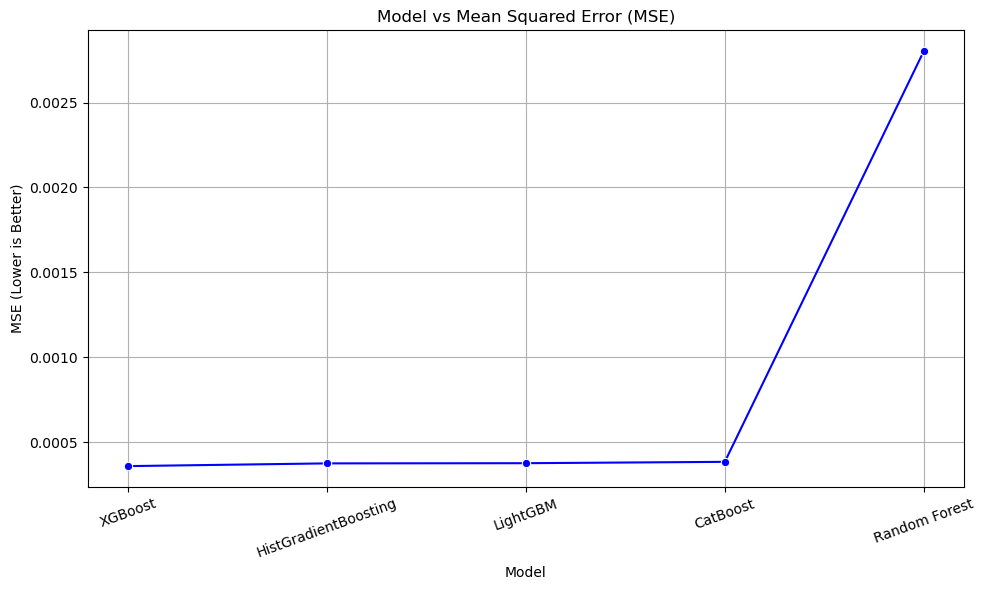

/tmp/ipykernel_23738/699800798.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_df, x='Model', y='Time (s)', palette='magma')


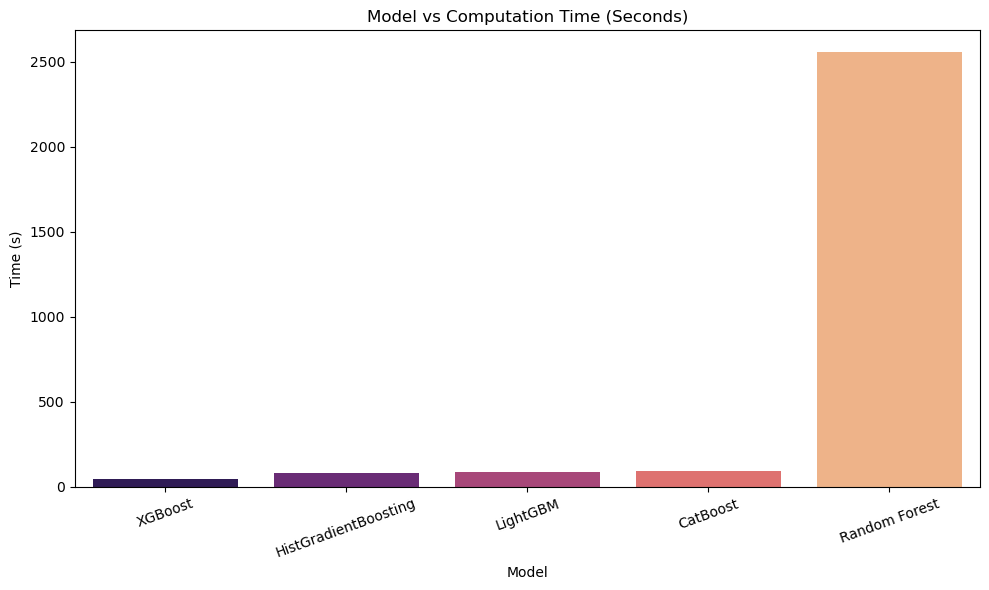

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by MSE (optional, for better visuals)
sorted_df = results_df[['MSE', 'Time (s)']].sort_values('MSE').reset_index()
sorted_df.rename(columns={'index': 'Model'}, inplace=True)

# Plot MSE
plt.figure(figsize=(10, 6))
sns.lineplot(data=sorted_df, x='Model', y='MSE', marker='o', color='blue')
plt.title('Model vs Mean Squared Error (MSE)')
plt.xticks(rotation=20)
plt.ylabel('MSE (Lower is Better)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot Time
plt.figure(figsize=(10, 6))
sns.barplot(data=sorted_df, x='Model', y='Time (s)', palette='magma')
plt.title('Model vs Computation Time (Seconds)')
plt.xticks(rotation=20)
plt.ylabel('Time (s)')
plt.xlabel('Model')
plt.tight_layout()
plt.show()
